In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras 
from keras.layers import *
from keras.models import *
from keras.preprocessing.image import ImageDataGenerator
import glob
from sklearn.model_selection import train_test_split
from keras.applications import *
import cv2

In [2]:
gen = []
label = []
for i in glob.glob('dogs-vs-cats/train/train/*'):
    if i.split('\\')[1].split('.')[0] == 'cat':
        gen.append(i)
        label.append(0)
    elif i.split('\\')[1].split('.')[0] == 'dog':
        gen.append(i)
        label.append(1)
    else:
        print('erorr')

In [3]:
gen[12499], label[12499]

('dogs-vs-cats/train/train\\cat.9999.jpg', 0)

In [4]:
x_train, x_test, y_train, y_test = train_test_split(gen, label, train_size=0.9, random_state=0, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.9, random_state=0, shuffle=True)

In [5]:
len(x_train), len(x_test), len(x_val)

(20250, 2500, 2250)

In [6]:
df_train = pd.DataFrame({'filename' : x_train, 'label': y_train})
df_train["label"] = df_train["label"].astype('str')
df_test = pd.DataFrame({'filename' : x_test, 'label': y_test})
df_test["label"] = df_test["label"].astype('str')
df_val = pd.DataFrame({'filename' : x_val, 'label': y_val})
df_val["label"] = df_val["label"].astype('str')

In [7]:
train_gen = ImageDataGenerator(rotation_range=40, preprocessing_function=imagenet_utils.preprocess_input, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, horizontal_flip=True, fill_mode='nearest', zoom_range= 0.2)
# train_gen = ImageDataGenerator(rescale=1./255)
train = train_gen.flow_from_dataframe(df_train,x_col='filename', y_col='label', target_size=(150, 150), class_mode='binary')
test_gen = ImageDataGenerator(preprocessing_function=imagenet_utils.preprocess_input)
test = test_gen.flow_from_dataframe(df_test,x_col='filename', y_col='label', target_size=(150, 150), class_mode='binary')
val_gen = ImageDataGenerator(preprocessing_function=imagenet_utils.preprocess_input)
val = val_gen.flow_from_dataframe(df_val,x_col='filename', y_col='label', target_size=(150, 150),  class_mode='binary')

Found 20250 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2250 validated image filenames belonging to 2 classes.


In [8]:
batch_size = 32
conv_base = VGG16(include_top=False, input_shape=(150, 150, 3))
def extract_features(t, sample_size):
    features = np.zeros(shape=(sample_size, 4, 4, 512))
    labels = np.zeros(shape=(sample_size))
    i = 0
    for feature, label in t:
        feature_pred = conv_base.predict(feature)
        features[i * batch_size : (i + 1) * batch_size] = feature_pred
        labels[i * batch_size : (i + 1) * batch_size] = label
        i += 1
        if i * batch_size >= sample_size:
            break
    return features, labels
# train_feature, train_label = extract_features(train, 16000)
# val_feature, val_label = extract_features(val, 4000)

In [9]:
# model = Sequential()
# model.add(Conv2D(64, (3, 3), input_shape = (150, 150, 3), activation='relu'))
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(256, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(256, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2, 2)))
# model.add(Flatten())
# model.add(Dropout(0.5))
# model.add(Dense(512, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
# model.summary()
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# history = model.fit(train, validation_data=val, steps_per_epoch = 500, epochs = 30, validation_steps = 125, callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True))

In [13]:
conv_base = VGG16(include_top=False, input_shape=(150, 150, 3))
conv_base.trainable = False
model1 = Sequential()
model1.add(conv_base)
model1.add(Flatten())
model1.add(Dense(256, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model1.fit(train, validation_data=val, batch_size=32,steps_per_epoch=200, epochs=30, callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True))
model1.summary()

Epoch 1/30
200/200 [==============================] - 45s 222ms/step - loss: 1.0723 - accuracy: 0.9091 - val_loss: 0.2144 - val_accuracy: 0.9569
Epoch 2/30
200/200 [==============================] - 44s 221ms/step - loss: 0.1842 - accuracy: 0.9352 - val_loss: 0.2040 - val_accuracy: 0.9516
Epoch 3/30
200/200 [==============================] - 44s 220ms/step - loss: 0.1569 - accuracy: 0.9420 - val_loss: 0.1278 - val_accuracy: 0.9587
Epoch 4/30
200/200 [==============================] - 45s 224ms/step - loss: 0.1441 - accuracy: 0.9432 - val_loss: 0.1026 - val_accuracy: 0.9698
Epoch 5/30
200/200 [==============================] - 44s 218ms/step - loss: 0.1427 - accuracy: 0.9425 - val_loss: 0.1418 - val_accuracy: 0.9618
Epoch 6/30
200/200 [==============================] - 44s 220ms/step - loss: 0.1223 - accuracy: 0.9525 - val_loss: 0.1120 - val_accuracy: 0.9693
Epoch 7/30
200/200 [==============================] - 44s 220ms/step - loss: 0.1178 - accuracy: 0.9503 - val_loss: 0.1003 - val_ac

In [15]:
print(f'\ntrain: {model1.evaluate(train)}', f'val: {model1.evaluate(val)}', f'test: {model1.evaluate(test)}', sep='\n-------------------------------------------------->\n')

79/79 [==============================] - 5s 63ms/step - loss: 0.0725 - accuracy: 0.9776

train: [0.11281690001487732, 0.9541728496551514]
-------------------------------------------------->
val: [0.0816173329949379, 0.9746666550636292]
-------------------------------------------------->
test: [0.07249817252159119, 0.9775999784469604]


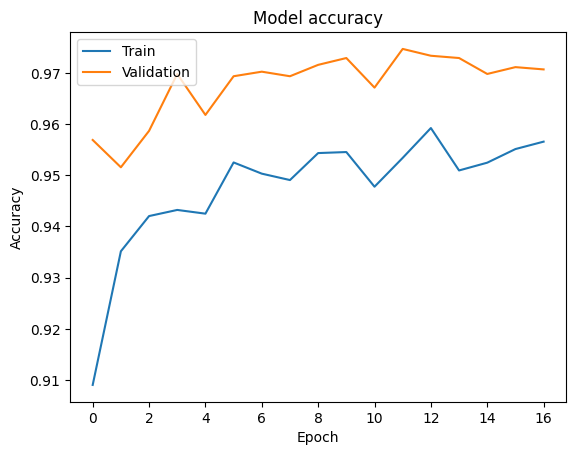

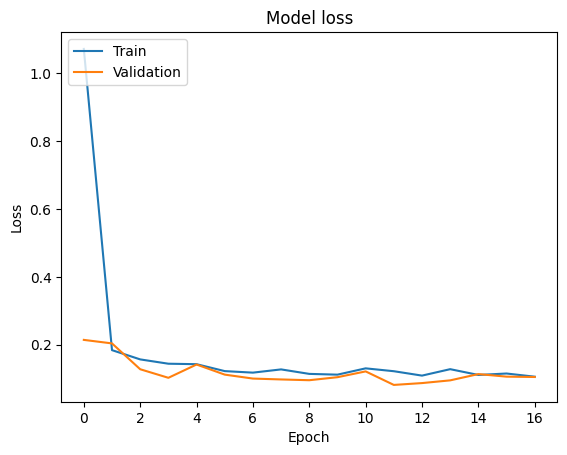

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 40ms/step
	Your pet is: Cat			Your pet is: Dog


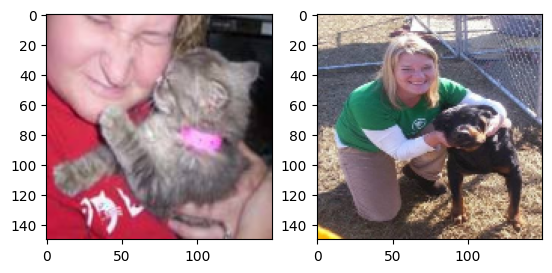

In [16]:
img1 = cv2.imread(r"F:\2277.jpg")
img2 = cv2.imread(r"F:\212.jpg")

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

img1 = cv2.resize(img1, (150, 150))
img2 = cv2.resize(img2, (150, 150))

plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.subplot(1, 2, 2)
plt.imshow(img2)

img1 = np.expand_dims(img1, axis=0)
img1 = np.reshape(img1, (1, 150, 150, 3))
img1 = imagenet_utils.preprocess_input(img1)


img2 = np.expand_dims(img2, axis=0)
img2 = np.reshape(img2, (1, 150, 150, 3))
img2 = imagenet_utils.preprocess_input(img2)

print(f"\tYour pet is: {['Cat', 'Dog'][int(round(model1.predict(img1)[0][0]))]}", f"Your pet is: {['Cat', 'Dog'][int(round(model1.predict(img2)[0][0]))]}", sep = "\t\t\t")